# Sarcasm Detection with BERT or DistilBERT

This notebook provides code which trains the sarcasm detection dataset using BERT or DistilBERT (a variable to switch which model is being used is provided in the Preprocessing section).

Training as shown in the code outputs here used the DistilBERT model and was run on Google Colab using a GPU.

'BERT Fine-Tuning Tutorial with Pytorch' by Chris McCormick and Nick Ryan (https://mccormickml.com/2019/07/22/BERT-fine-tuning) has been used as a close guide in this notebook and code snippets from their tutorial have been used here. Variations to their code include adapting the model to the news headlines dataset (with a custom Pytorch Dataset class), using DistilBERT (and providing functionality to switch between the two), and computing the testing data accuracy and prediction probabilities. 

In [1]:
import pandas as pd
import numpy as np

#### Import data

In [40]:
# Import training and test datasets
train_data = pd.read_csv("../data/train.csv")
test_data = pd.read_csv("../data/test.csv")
print(train_data.head())
print(test_data.head())

   is_sarcastic                                           headline
0             1  'you better give our dad a good trade deal or ...
1             0              an open letter to graduation speakers
2             0  donald trump makes dubious claim about inaugur...
3             1  pope francis clarifies that god just one of ma...
4             1  woman all geared up to complain about work sid...
   is_sarcastic                                           headline
0             0    how to make greek easter sweet bread "tsoureki"
1             1                   theodore roosevelt was a gay man
2             1  man at bar clinging to muted 'king of queens' ...
3             0  the one moment you need to see from last night...
4             0  'hedwig' takes home tony for best revival of a...


In [5]:
# Check that all text is lowercase
lowercase = np.append(train_data["headline"].str.islower(), test_data["headline"].str.islower())
print(f"All headlines lowercase: {lowercase.all()}")

# Check maximum number of words in headline dataset
headline_lengths = np.append(train_data["headline"].str.split(" ").str.len(), test_data["headline"].str.split(" ").str.len())
max_headline_length = headline_lengths.max()
print(f"Max headline lenght: {max_headline_length}")

All headlines lowercase: True
Max headline lenght: 151


BERT (and DistilBERT) can process a maximum of 512 tokens as its input. The headlines in this dataset are much shorter than this so no truncation will be needed (and rather, headlines will need to be padded with the [PAD] token so that all headlines are the same length. The Hugging Face transformer library's BertTokenizer/DistilBertTokenizer will do this during preprocessing.

All headlines are lowercase, so the uncased models will be used.

No headline exceeds 512 words - will not need to truncate any headlines but instead pad unused token slots for inputting into BERT model (as well as adding the [CLS] token). All headlines are all lowercase.

Following https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f

jks this one https://mccormickml.com/2019/07/22/BERT-fine-tuning/#1-setup

#### Preprocessing

In [6]:
# Install the Hugging Face transformers library
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.0 MB/s 
     |████████████████████████████████| 6.6 MB 47.0 MB/s 
     |████████████████████████████████| 101 kB 14.0 MB/s 
     |████████████████████████████████| 596 kB 34.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [7]:
import torch
# Import tokenizer classes
from transformers import BertTokenizer, DistilBertTokenizer

The (Distil)BertTokenizer classes process the text sequences into the form expected by the (Distil)BERT model.
 * Tokenize sentence and convert tokens to IDs
 * [CLS] (classification) tokens are added at the start of each sequence
 * [SEP] tokens are added at the end of each sentence
 * Pad unused token slots with [PAD] so that all sequences are the same length

 The tokenizer output contains input_ids, as well as the attention_mask, which indicates if the token is part of the sequence (1) or just padding (0).

In [8]:
# Switch between BERT and DistilBERT
# "bert" or "distilbert"
bert_type = "distilbert"

In [9]:
if bert_type == "distilbert":
  tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
else:
  tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [10]:
# Define custom pytorch Dataset class for Headlines
# adapted from https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f
class HeadlineDataset(torch.utils.data.Dataset):

    def __init__(self, df, tokenizer):
        self.labels = df['is_sarcastic']
        # tokenize input data for BERT
        # Padding strategy is pad sequences until max_length
        # return_tensors = "pt": return pytorch tensors (rather than tensorflow tensors)
        self.texts = [tokenizer(text, padding="max_length", max_length=256, return_tensors="pt") for text in df['headline']]
        
    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        batch_texts = self.texts[idx]
        batch_y = np.array(self.labels[idx])

        return batch_texts, batch_y
        

In [11]:
dataset = HeadlineDataset(train_data, tokenizer)
test_dataset = HeadlineDataset(test_data, tokenizer)

In [12]:
# 90:10 split for training/validation (using validation to detect any overfitting)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

print(len(train_dataset), len(val_dataset), len(test_dataset))

19317 2147 7155


In [13]:
# Code from https://mccormickml.com/2019/07/22/BERT-fine-tuning/

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 16

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

#### Model

In [14]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


We use either the BERT base model or the DistilBERT base model. The BERT base model has 12 transformer layers and around 110M parameters. DistilBERT optimizes BERT's training performance, being smaller and faster to train than BERT, with only a small tradeoff in performance.


The Hugging Face library provides interfaces for (Distil)BERT sequence classification, which adds an additional linear layer for fine tuning on top of the pretrained (Distil)BERT layer. The BERT layer outputs embedding vectors of size 768 for each token. The linear layer then takes the embedding vector for the [CLS] token as input (the pooled output), and uses this to classify the sequence as either sarcastic or not sarcastic.

In [15]:
# Adapted from https://mccormickml.com/2019/07/22/BERT-fine-tuning

from transformers import BertForSequenceClassification, BertConfig, \
                              DistilBertForSequenceClassification, DistilBertConfig

# Load (Distil)BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
if bert_type == "distilbert":
  model_class = DistilBertForSequenceClassification
  # Use the DistilBERT model (6 encoder layers), with uncased vocab
  vocab = "distilbert-base-uncased"
else:
  model_class = BertForSequenceClassification
  # Use the 12-layer BERT model, with an uncased vocab.
  vocab = "bert-base-uncased"

model = model_class.from_pretrained(
    vocab,
    num_labels = 2, # The number of output labels--2 for binary classification.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classi

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

BERT paper recommends:
* Batch size: 16, 32
* Learning rate (Adam): 5e-5, 3e-5, 2e-5
* Number of epochs: 2, 3, 4

In [16]:
# Number of training epochs.
epochs = 3

In [17]:
### Code from https://mccormickml.com/2019/07/22/BERT-fine-tuning ###

from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

#### Training loop

In [18]:
# Code from https://mccormickml.com/2019/07/22/BERT-fine-tuning
import time
import datetime

# For printing elapsed time during training
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

  
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [19]:
### Code from https://mccormickml.com/2019/07/22/BERT-fine-tuning ###
# Adapted to the HeadlineDataset class

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()


# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    # Iterating through train_dataloader gives (tokenizer_output, label)
    for step, (batch_input, batch_labels) in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader and copy tensors to GPU. 
        #
        # `batch_input` is an object containing the tokenizer output including 
        #   input_ids and attention masks
        b_input_ids = batch_input.input_ids.squeeze(1).to(device)
        b_input_mask = batch_input.attention_mask.to(device)

        b_labels = batch_labels.to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        model_output = model(b_input_ids, attention_mask=b_input_mask, 
                               labels=b_labels)
        loss = model_output.loss
        logits = model_output.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch_input.input_ids.squeeze(1).to(device)
        b_input_mask = batch_input.attention_mask.to(device)
        b_labels = batch_labels.to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            model_output = model(b_input_ids, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
            loss = model_output.loss
            logits = model_output.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of  1,208.    Elapsed: 0:00:17.
  Batch    80  of  1,208.    Elapsed: 0:00:30.
  Batch   120  of  1,208.    Elapsed: 0:00:42.
  Batch   160  of  1,208.    Elapsed: 0:00:55.
  Batch   200  of  1,208.    Elapsed: 0:01:08.
  Batch   240  of  1,208.    Elapsed: 0:01:21.
  Batch   280  of  1,208.    Elapsed: 0:01:35.
  Batch   320  of  1,208.    Elapsed: 0:01:48.
  Batch   360  of  1,208.    Elapsed: 0:02:02.
  Batch   400  of  1,208.    Elapsed: 0:02:15.
  Batch   440  of  1,208.    Elapsed: 0:02:28.
  Batch   480  of  1,208.    Elapsed: 0:02:41.
  Batch   520  of  1,208.    Elapsed: 0:02:55.
  Batch   560  of  1,208.    Elapsed: 0:03:08.
  Batch   600  of  1,208.    Elapsed: 0:03:21.
  Batch   640  of  1,208.    Elapsed: 0:03:35.
  Batch   680  of  1,208.    Elapsed: 0:03:48.
  Batch   720  of  1,208.    Elapsed: 0:04:02.
  Batch   760  of  1,208.    Elapsed: 0:04:15.
  Batch   800  of  1,208.    Elapsed: 0:04:28.
  Batch   840  of

In [20]:
### Code from https://mccormickml.com/2019/07/22/BERT-fine-tuning ###
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.29,3.70e-01,0.8,0:06:46,0:00:05
2,0.14,1.65e-03,1.0,0:06:51,0:00:05
3,0.07,6.35e-04,1.0,0:06:52,0:00:05


In [23]:
import pickle

pickle.dump(model, open(f"training_stats_{bert_type}_{epochs}.pkl", 'wb'))

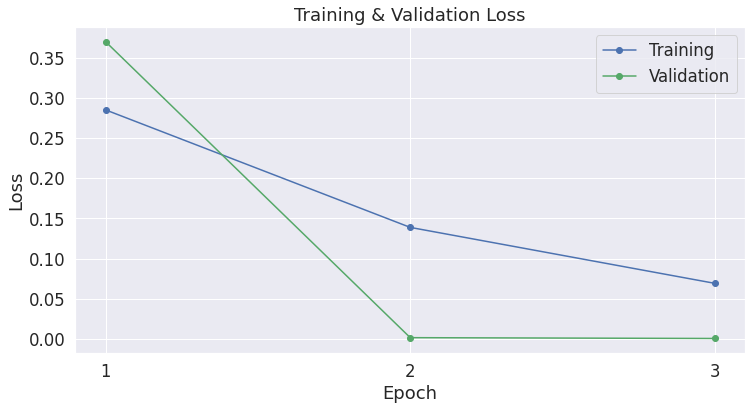

In [22]:
### Code from https://mccormickml.com/2019/07/22/BERT-fine-tuning ###
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3])

plt.show()

In this instance, it does not seem that the model is overfitting as validation loss does not decrease. In the future, it may be worth exploring if 2 epochs would be sufficient.

#### Testing

In [24]:
test_dataloader = DataLoader(
            test_dataset, # The test samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
      )

In [25]:
### Code from https://mccormickml.com/2019/07/22/BERT-fine-tuning ###
### Adapted for HeadlineDataset class, and adapted to output overall accuracy ###

# Prediction on test set
print('Predicting labels for {:,} test sentences...'.format(len(test_dataset)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

total_eval_accuracy = 0
# Predict 
for (batch, labels) in test_dataloader:
  
  # Unpack the inputs from our dataloader
  b_input_ids = batch.input_ids.squeeze(1).to(device)
  b_input_mask = batch.attention_mask.to(device)
  b_labels = labels.to(device)
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, attention_mask=b_input_mask)

  logits = outputs[0]


  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  total_eval_accuracy += flat_accuracy(logits, label_ids)
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)


avg_val_accuracy = total_eval_accuracy / len(test_dataloader)
print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

print('    DONE.')

Predicting labels for 7,155 test sentences...
  Accuracy: 0.92
    DONE.


In [53]:
def flatten(l):
    return [item for sublist in l for item in sublist]

logits_flat = flatten(predictions)
true_labels_flat = flatten(true_labels)

In [54]:
pickle.dump(logits_flat, open(f"logits_{bert_type}_{epochs}.pkl", 'wb'))

In [59]:
# Logits format
# Logits are before softmax has been applied
logits_flat[:10]

[array([ 4.1237855, -3.8281298], dtype=float32),
 array([ 3.7704358, -3.4779158], dtype=float32),
 array([-3.5091205,  4.1441984], dtype=float32),
 array([ 3.9656198, -3.618839 ], dtype=float32),
 array([ 2.2845676, -2.0641358], dtype=float32),
 array([-3.2614179,  3.8259752], dtype=float32),
 array([-1.4869041,  1.6592325], dtype=float32),
 array([ 3.7774732, -3.4328878], dtype=float32),
 array([0.23908372, 0.04929967], dtype=float32),
 array([ 3.642096 , -3.2914076], dtype=float32)]

In [61]:
# Compute accuracy

# Get predictions (0 or 1 for not sarcastic or sarcastic)
pred_flat = np.argmax(logits_flat, axis=1).flatten()

# sum predictions that are the same and divide by number of samples
np.sum(pred_flat == true_labels_flat) / len(true_labels_flat)

0.9218728162124389

In [62]:
# Get prediction probabiltiies from logits

# Pytorch softmax function to convert logits into probability distribution
softmax = torch.nn.Softmax(dim = 1)

# apply softmax to logits
prediction_probabilities = softmax(torch.Tensor(logits_flat))
prediction_probabilities[:10]

tensor([[9.9965e-01, 3.5186e-04],
        [9.9929e-01, 7.1084e-04],
        [4.7424e-04, 9.9953e-01],
        [9.9949e-01, 5.0803e-04],
        [9.8724e-01, 1.2759e-02],
        [8.3488e-04, 9.9917e-01],
        [4.1244e-02, 9.5876e-01],
        [9.9926e-01, 7.3834e-04],
        [5.4730e-01, 4.5270e-01],
        [9.9903e-01, 9.7363e-04]])

In [63]:
pickle.dump(prediction_probabilities, open(f"prediction_probabilities_{bert_type}_{epochs}.pkl", 'wb'))